### Survival Analysis with Survival Forests testing

import what you need

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder

set_config(display="text")

load in dataset, transform it into numerical values

In [2]:
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

split data into train and test (75, 25)

In [3]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

set up and train the rsf model using a forest made of 1,000 trees

In [4]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=random_state
)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

check model performance using c-index

In [5]:
c_index = rsf.score(X_test, y_test)
f"{c_index:.5f}"

'0.67453'

this is apparently a decent value according to sci-kit user guide - https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html

#### Prediction

In [ ]:
X_test_sorted = X_test.sort_values(by=["pnodes", "age"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

In [ ]:
pd.Series(rsf.predict(X_test_sel))
#pd.Series(rsf.predict(X_test))

predict risk scores

In [6]:
risk_scores = rsf.predict(X_test)
print(risk_scores[:10]) # first 10 scored

[ 30.82465024  50.13296562 154.0226118   35.77292704  92.61021789
  67.42108036  26.59971408  99.539617    90.52234803  27.86286772]


predict survival functions

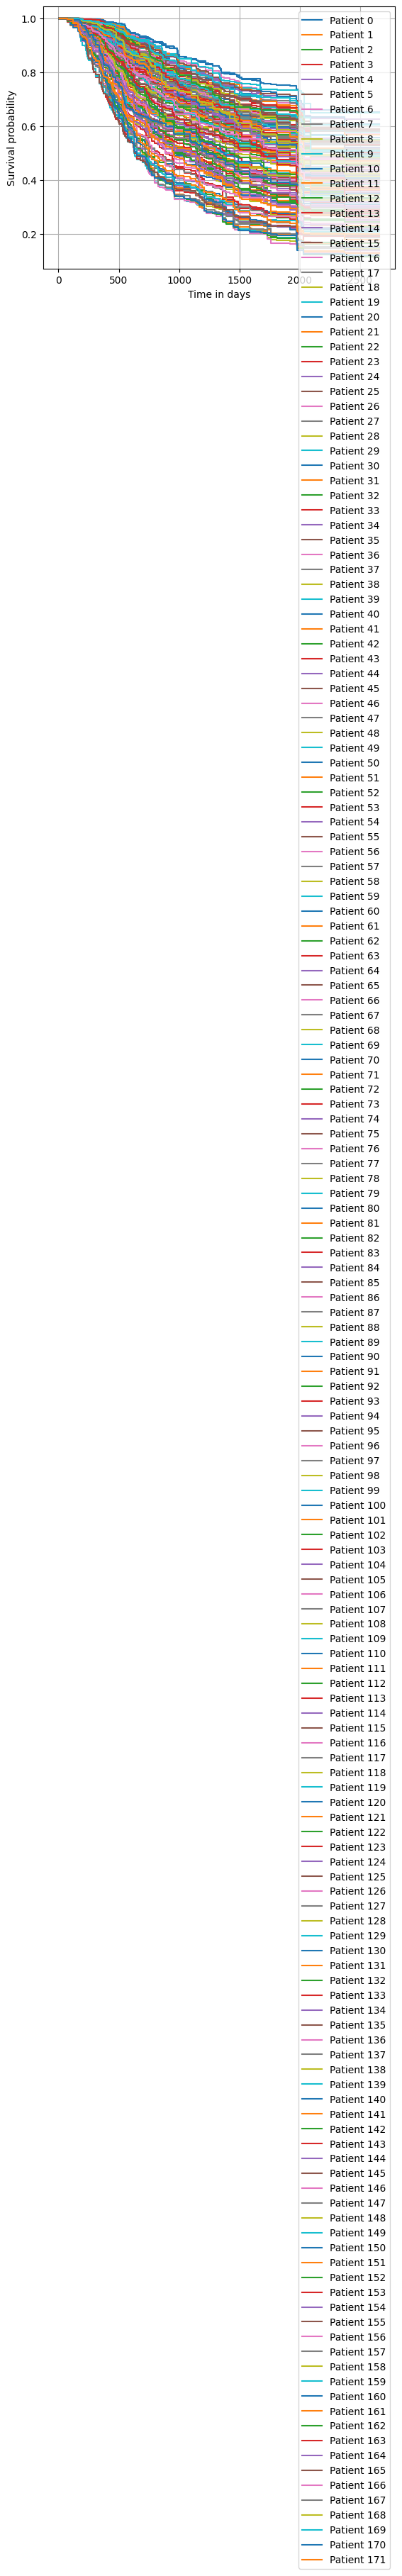

In [7]:
surv = rsf.predict_survival_function(X_test, return_array=True)
for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=f"Patient {i}")

plt.xlabel("Time in days")
plt.ylabel("Survival probability")
plt.legend()
plt.grid(True)
plt.show()

#### Feature Importance

scikit-survival cannot use scikit-learns definition of feature importance. That is okay because it is defined differently in the official Random Forest paper. Instead we use permutation to estimate feature importance.

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=random_state)

In [ ]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)